### 학습 시 데이터를 섞는 shuffle 적용 유무에 다른 성능 테스트

In [1]:
import tensorflow as tf
import numpy as np
import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# set random seed
def set_random_seed(seed_value):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

def get_preprocessed_data(images, labels):
    
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    
    return images, labels

def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels)
    
    oh_labels = to_categorical(labels)
    return images, oh_labels

def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels ) 

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
from tensorflow.keras.datasets import cifar10

set_random_seed(2021)

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)

print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
(42500, 32, 32, 3) (42500, 10) (7500, 32, 32, 3) (7500, 10) (10000, 32, 32, 3) (10000, 10)


In [6]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

IMAGE_SIZE=32

def create_model():
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
    x = Activation('relu')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Flatten(name='flatten')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(300, activation='relu', name='fc1')(x)
    x = Dropout(rate=0.3)(x)
    output = Dense(10, activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)
    model.summary()
    
    return model

### shuffle=False

In [8]:
model = create_model()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

no_shuffle_history = model.fit(
    x=tr_images,
    y=tr_oh_labels,
    batch_size=64,
    epochs=30,
    shuffle=False,
    validation_data=(val_images, val_oh_labels)
)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0   

2021-08-19 20:08:14.773956: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-19 20:08:14.777036: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/30


2021-08-19 20:08:15.016452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


665/665 [==============================] - ETA: 0s - loss: 1.5751 - accuracy: 0.4301

2021-08-19 20:08:38.102101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


665/665 [==============================] - 25s 35ms/step - loss: 1.5751 - accuracy: 0.4301 - val_loss: 1.3808 - val_accuracy: 0.4915
Epoch 2/30
665/665 [==============================] - 23s 34ms/step - loss: 1.0907 - accuracy: 0.6110 - val_loss: 1.5559 - val_accuracy: 0.5064
Epoch 3/30
665/665 [==============================] - 23s 34ms/step - loss: 0.8974 - accuracy: 0.6830 - val_loss: 0.8031 - val_accuracy: 0.7213
Epoch 4/30
665/665 [==============================] - 23s 34ms/step - loss: 0.7739 - accuracy: 0.7303 - val_loss: 1.0267 - val_accuracy: 0.6591
Epoch 5/30
665/665 [==============================] - 23s 34ms/step - loss: 0.6906 - accuracy: 0.7624 - val_loss: 0.8258 - val_accuracy: 0.7309
Epoch 6/30
665/665 [==============================] - 23s 34ms/step - loss: 0.6197 - accuracy: 0.7847 - val_loss: 1.0417 - val_accuracy: 0.6845
Epoch 7/30
665/665 [==============================] - 23s 34ms/step - loss: 0.5612 - accuracy: 0.8082 - val_loss: 0.9170 - val_accuracy: 0.7225
Epo

NameError: name 'evaluation_result' is not defined

In [9]:
evaluation_result = model.evaluate(
    test_images,
    test_oh_labels,
    batch_size=64
)

print('evaluation result: ', evaluation_result)

157/157 [==============================] - 2s 12ms/step - loss: 0.9642 - accuracy: 0.8048
evaluation result:  [0.9642027020454407, 0.8048000335693359]


In [10]:
# model이 반복적으로 메모리를 차지하는 것을 없애기 위해서 수행
tf.keras.backend.clear_session()

### shuffle=True

In [11]:
model = create_model()

model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

shuffle_history = model.fit(
    x=tr_images,
    y=tr_oh_labels,
    batch_size=64,
    epochs=30,
    shuffle=True,
    validation_data=(val_images, val_oh_labels)
)

evaluation_result = model.evaluate(
    test_images,
    test_oh_labels,
    batch_size=64
)

print('evaluation result: ', evaluation_result)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0     

2021-08-19 20:22:31.313322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


665/665 [==============================] - ETA: 0s - loss: 1.5989 - accuracy: 0.4228

2021-08-19 20:22:53.229063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


665/665 [==============================] - 23s 35ms/step - loss: 1.5989 - accuracy: 0.4228 - val_loss: 1.2889 - val_accuracy: 0.5391
Epoch 2/30
665/665 [==============================] - 22s 34ms/step - loss: 1.1428 - accuracy: 0.5922 - val_loss: 1.5511 - val_accuracy: 0.5037
Epoch 3/30
665/665 [==============================] - 22s 34ms/step - loss: 0.9375 - accuracy: 0.6674 - val_loss: 0.8902 - val_accuracy: 0.6861
Epoch 4/30
665/665 [==============================] - 22s 34ms/step - loss: 0.8069 - accuracy: 0.7183 - val_loss: 1.3118 - val_accuracy: 0.5568
Epoch 5/30
665/665 [==============================] - 22s 34ms/step - loss: 0.7368 - accuracy: 0.7434 - val_loss: 0.8305 - val_accuracy: 0.7097
Epoch 6/30
665/665 [==============================] - 22s 34ms/step - loss: 0.6606 - accuracy: 0.7704 - val_loss: 0.6913 - val_accuracy: 0.7649
Epoch 7/30
665/665 [==============================] - 22s 34ms/step - loss: 0.6059 - accuracy: 0.7897 - val_loss: 0.9481 - val_accuracy: 0.7140
Epo

### 앞서 수행한 shuffle 테스트 시 validation 데이터 기반 성능 검증 시각화

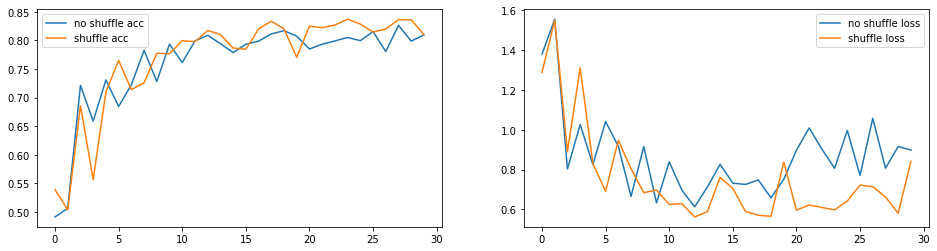

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history_shuffle(no_shuffle_history, shuffle_history):
    
    figure, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
    
    # shuffle과 no shuffle의 validation accuracy 비교
    axs[0].plot(no_shuffle_history.history['val_accuracy'], label='no shuffle acc')
    axs[0].plot(shuffle_history.history['val_accuracy'], label='shuffle acc')
    
    # shuffle과 no shuffle의 validation loss 비교
    axs[1].plot(no_shuffle_history.history['val_loss'], label='no shuffle loss')
    axs[1].plot(shuffle_history.history['val_loss'], label='shuffle loss')
    
    # legend
    axs[0].legend()
    axs[1].legend()
    
show_history_shuffle(no_shuffle_history, shuffle_history)

In [14]:
tf.keras.backend.clear_session()

### Batch Size 32, 64, 256, 512

In [15]:
b_sizes = [32, 64, 256, 512]
histories = []
evaluations = []
for b_size in b_sizes:
    model = create_model()
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    # batch_size를 순차적으로 32, 64, 256, 512로 변경하여 학습 및 evaluation 수행. 
    print('##### batch size :', b_size, '학습 #####')
    history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=b_size, epochs=30, 
                        shuffle=True, validation_data=(val_images, val_oh_labels))
    # batch size별 학습 history 결과 저장. 
    histories.append(history)
    # 테스트 세트로 evaluation 수행하고 batch size별 결과 저장. 
    evaluation_result = model.evaluate(test_images, test_oh_labels, batch_size=b_size)
    print('#### 테스트 세트로 evaluation 결과 :', evaluation_result)
    evaluations.append(evaluation_result)
    
    tf.keras.backend.clear_session()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0     

2021-08-19 20:39:11.527228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - ETA: 0s - loss: 1.5718 - accuracy: 0.4348

2021-08-19 20:39:38.700583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - 29s 21ms/step - loss: 1.5718 - accuracy: 0.4348 - val_loss: 1.3374 - val_accuracy: 0.5203
Epoch 2/30
1329/1329 [==============================] - 29s 22ms/step - loss: 1.1042 - accuracy: 0.6072 - val_loss: 0.9914 - val_accuracy: 0.6404
Epoch 3/30
1329/1329 [==============================] - 28s 21ms/step - loss: 0.9055 - accuracy: 0.6817 - val_loss: 0.8176 - val_accuracy: 0.7127
Epoch 4/30
1329/1329 [==============================] - 28s 21ms/step - loss: 0.7991 - accuracy: 0.7233 - val_loss: 0.7620 - val_accuracy: 0.7369
Epoch 5/30
1329/1329 [==============================] - 28s 21ms/step - loss: 0.7127 - accuracy: 0.7540 - val_loss: 0.7253 - val_accuracy: 0.7544
Epoch 6/30
1329/1329 [==============================] - 28s 21ms/step - loss: 0.6409 - accuracy: 0.7803 - val_loss: 0.7200 - val_accuracy: 0.7577
Epoch 7/30
1329/1329 [==============================] - 28s 21ms/step - loss: 0.5855 - accuracy: 0.7985 - val_loss: 0.6544 - val_accura

Epoch 1/30
  1/665 [..............................] - ETA: 4:10 - loss: 4.2269 - accuracy: 0.0312

2021-08-19 20:53:35.404690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


665/665 [==============================] - ETA: 0s - loss: 1.5858 - accuracy: 0.4266

2021-08-19 20:53:59.131573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


665/665 [==============================] - 25s 38ms/step - loss: 1.5858 - accuracy: 0.4266 - val_loss: 1.6944 - val_accuracy: 0.4369
Epoch 2/30
665/665 [==============================] - 25s 38ms/step - loss: 1.1177 - accuracy: 0.6001 - val_loss: 1.2848 - val_accuracy: 0.5639
Epoch 3/30
665/665 [==============================] - 25s 38ms/step - loss: 0.9192 - accuracy: 0.6773 - val_loss: 1.1052 - val_accuracy: 0.6233
Epoch 4/30
665/665 [==============================] - 26s 40ms/step - loss: 0.7945 - accuracy: 0.7194 - val_loss: 0.8088 - val_accuracy: 0.7155
Epoch 5/30
665/665 [==============================] - 26s 38ms/step - loss: 0.7140 - accuracy: 0.7520 - val_loss: 0.7247 - val_accuracy: 0.7523
Epoch 6/30
665/665 [==============================] - 25s 37ms/step - loss: 0.6509 - accuracy: 0.7748 - val_loss: 0.6872 - val_accuracy: 0.7663
Epoch 7/30
665/665 [==============================] - 24s 37ms/step - loss: 0.5837 - accuracy: 0.7992 - val_loss: 0.7089 - val_accuracy: 0.7587
Epo

Epoch 1/30


2021-08-19 21:06:12.125661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


166/167 [============================>.] - ETA: 0s - loss: 1.7581 - accuracy: 0.3691

2021-08-19 21:06:32.403246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


167/167 [==============================] - 22s 122ms/step - loss: 1.7580 - accuracy: 0.3691 - val_loss: 3.2260 - val_accuracy: 0.1199
Epoch 2/30
167/167 [==============================] - 20s 123ms/step - loss: 1.2541 - accuracy: 0.5432 - val_loss: 2.3233 - val_accuracy: 0.2793
Epoch 3/30
167/167 [==============================] - 21s 123ms/step - loss: 1.1306 - accuracy: 0.5971 - val_loss: 1.3054 - val_accuracy: 0.5473
Epoch 4/30
167/167 [==============================] - 21s 123ms/step - loss: 0.9152 - accuracy: 0.6746 - val_loss: 0.9651 - val_accuracy: 0.6624
Epoch 5/30
167/167 [==============================] - 21s 124ms/step - loss: 0.8151 - accuracy: 0.7112 - val_loss: 1.1857 - val_accuracy: 0.6133
Epoch 6/30
167/167 [==============================] - 21s 125ms/step - loss: 0.8396 - accuracy: 0.7055 - val_loss: 0.9200 - val_accuracy: 0.6863
Epoch 7/30
167/167 [==============================] - 21s 126ms/step - loss: 0.7049 - accuracy: 0.7513 - val_loss: 1.2530 - val_accuracy: 0.6

Epoch 1/30


2021-08-19 21:16:44.699483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - ETA: 0s - loss: 2.0962 - accuracy: 0.2850

2021-08-19 21:17:05.113223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - 22s 243ms/step - loss: 2.0962 - accuracy: 0.2850 - val_loss: 2.9291 - val_accuracy: 0.1099
Epoch 2/30
84/84 [==============================] - 20s 239ms/step - loss: 1.5030 - accuracy: 0.4478 - val_loss: 3.5511 - val_accuracy: 0.1195
Epoch 3/30
84/84 [==============================] - 20s 239ms/step - loss: 1.3998 - accuracy: 0.4963 - val_loss: 3.9187 - val_accuracy: 0.1240
Epoch 4/30
84/84 [==============================] - 20s 244ms/step - loss: 1.1721 - accuracy: 0.5773 - val_loss: 3.1437 - val_accuracy: 0.2109
Epoch 5/30
84/84 [==============================] - 20s 241ms/step - loss: 1.0782 - accuracy: 0.6165 - val_loss: 2.1978 - val_accuracy: 0.3288
Epoch 6/30
84/84 [==============================] - 21s 245ms/step - loss: 1.0458 - accuracy: 0.6315 - val_loss: 1.3412 - val_accuracy: 0.5245
Epoch 7/30
84/84 [==============================] - 21s 246ms/step - loss: 0.9089 - accuracy: 0.6772 - val_loss: 1.5827 - val_accuracy: 0.5197
Epoch 8/30

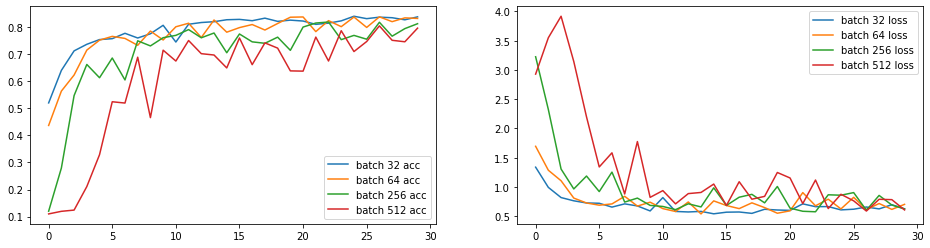

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history_batch(histories):
    figure, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))  
    # batch 크기별 validation accuracy 비교 
    axs[0].plot(histories[0].history['val_accuracy'], label='batch 32 acc')
    axs[0].plot(histories[1].history['val_accuracy'], label='batch 64 acc')
    axs[0].plot(histories[2].history['val_accuracy'], label='batch 256 acc')
    axs[0].plot(histories[3].history['val_accuracy'], label='batch 512 acc')
    
    # batch 크기별 validation loss 비교
    axs[1].plot(histories[0].history['val_loss'], label='batch 32 loss')
    axs[1].plot(histories[1].history['val_loss'], label='batch 64 loss')
    axs[1].plot(histories[2].history['val_loss'], label='batch 256 loss')
    axs[1].plot(histories[3].history['val_loss'], label='batch 512 loss')
    
    axs[0].legend()
    axs[1].legend()

show_history_batch(histories)